<a href="https://colab.research.google.com/github/ShlokArora2709/Mentorness_Internship/blob/main/Mentorness_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [ ]:
!pip install pmdarima

In [40]:
df= pd.read_csv('/content/drive/MyDrive/Copy of goldstock.csv')
df.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Date        2511 non-null   object 
 2   Close       2511 non-null   float64
 3   Volume      2511 non-null   float64
 4   Open        2511 non-null   float64
 5   High        2511 non-null   float64
 6   Low         2511 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.4+ KB


In [42]:
df=df.drop(df.columns[0],axis=1)
df

,Date,Close,Volume,Open,High,Low
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1
...,...,...,...,...,...,...
2506,2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0
2507,2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0
2508,2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9
2509,2014-01-23,1262.5,41697.0,1235.1,1267.1,1230.8


In [43]:
df["Date"] = pd.to_datetime(df['Date'])  # Convert date column to datetime
df.set_index("Date", inplace=True)
df

,Close,Volume,Open,High,Low
Date,,,,,
2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1
...,...,...,...,...,...
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9


In [ ]:
df.index

DatetimeIndex(['2024-01-19', '2024-01-18', '2024-01-17', '2024-01-16',
               '2024-01-12', '2024-01-11', '2024-01-10', '2024-01-09',
               '2024-01-08', '2024-01-05',
               ...
               '2014-02-04', '2014-02-03', '2014-01-31', '2014-01-30',
               '2014-01-29', '2014-01-28', '2014-01-27', '2014-01-24',
               '2014-01-23', '2014-01-22'],
              dtype='datetime64[ns]', name='Date', length=2511, freq=None)

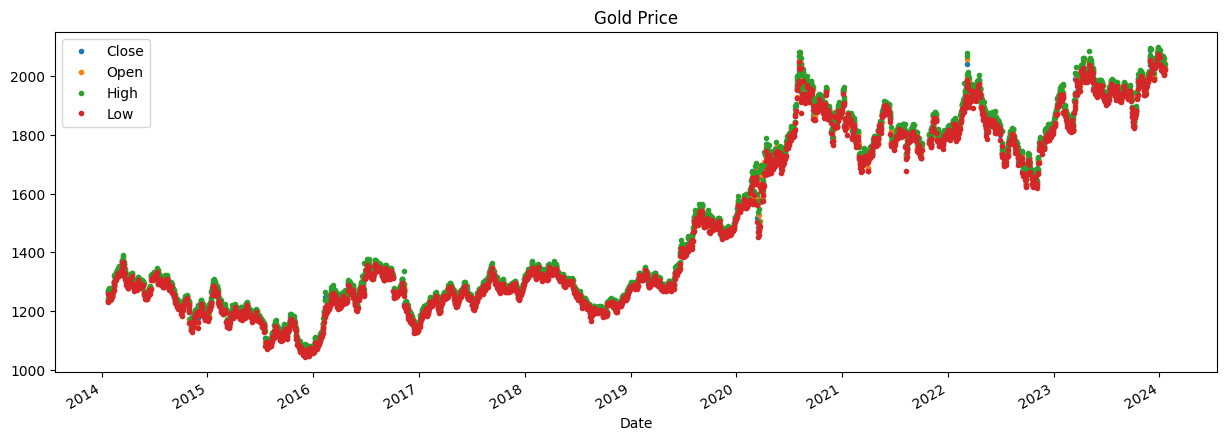

In [7]:
df.drop(['Volume'],axis=1).plot(style='.',
        figsize=(15, 5),
        title='Gold Price')
plt.show()

<Axes: ylabel='Frequency'>

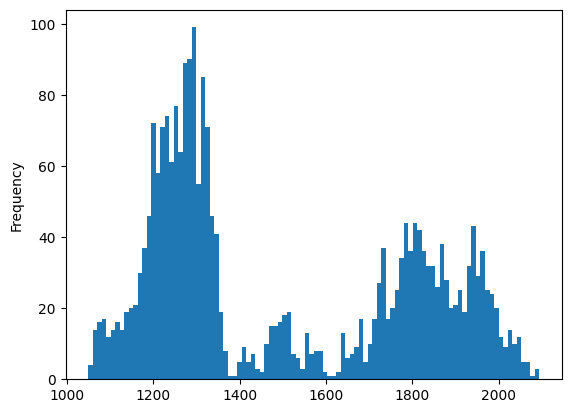

In [8]:
df['Close'].plot(kind='hist', bins=100)

In [ ]:
trace1 = go.Scatter(
    x=df["Date"],
    y=df["Open"],
    name="Open",
    mode="lines",
    marker=dict(color="blue")
)

trace2 = go.Scatter(
    x=df["Date"],
    y=df["Close"],
    name="Close",
    mode="lines",
    marker=dict(color="red")
)




In [ ]:
layout = go.Layout(
    title="Open and Close Prices over Date",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis_tickformat="%Y",
)


fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

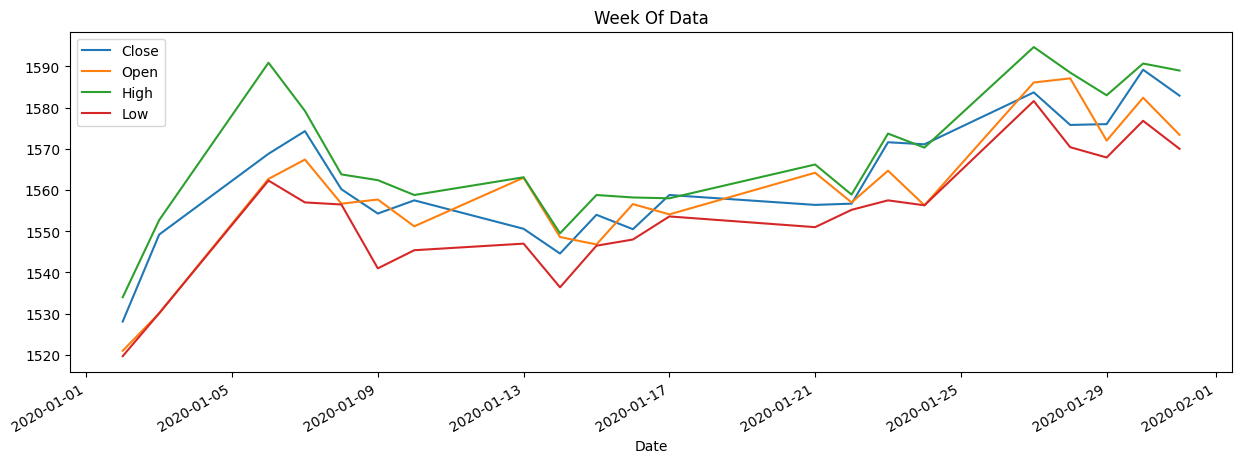

In [ ]:
df.drop(['Volume'],axis=1).loc[(df.index > '01-01-2020') & (df.index < '02-01-2020')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)
df = df.sort_index()

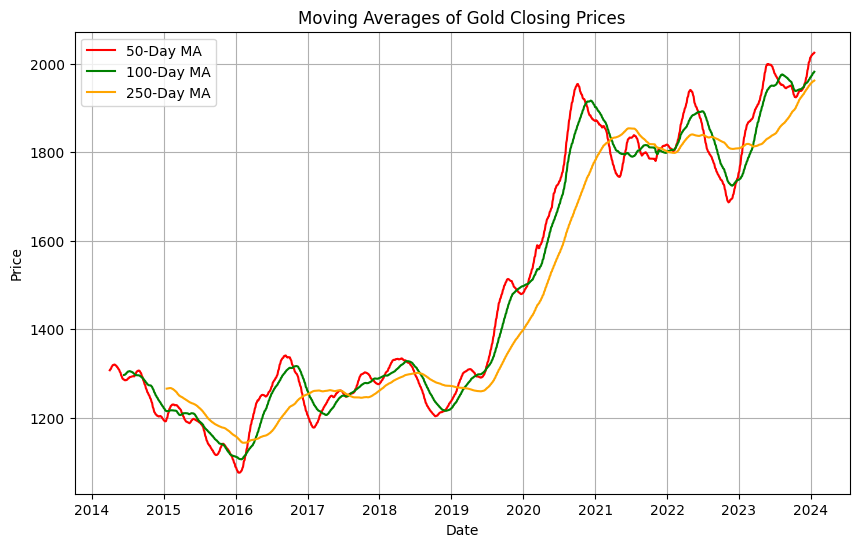

In [10]:
ma_50 = df['Close'].rolling(window=50).mean()
ma_100 = df['Close'].rolling(window=100).mean()
ma_250 = df['Close'].rolling(window=250).mean()

plt.figure(figsize=(10, 6))
plt.plot(df.index, ma_50, label='50-Day MA', color='red')
plt.plot(df.index, ma_100, label='100-Day MA', color='green')
plt.plot(df.index, ma_250, label='250-Day MA', color='orange')

plt.title('Moving Averages of Gold Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def calculate_RSI(prices, period=50):
    gains = losses = 0
    for i in range(1, len(prices)):
        price_diff = prices[i] - prices[i - 1]
        if price_diff > 0:
            gains += price_diff
        elif price_diff < 0:
            losses += abs(price_diff)
    avg_gain = gains / period
    avg_loss = losses / period
    rs = avg_gain / avg_loss if avg_loss != 0 else 0
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
close_prices = df['Close']
rsi_values = [calculate_RSI(close_prices[i-50:i+1]) if i >= 50 else None for i in range(len(close_prices))]
rsi_values

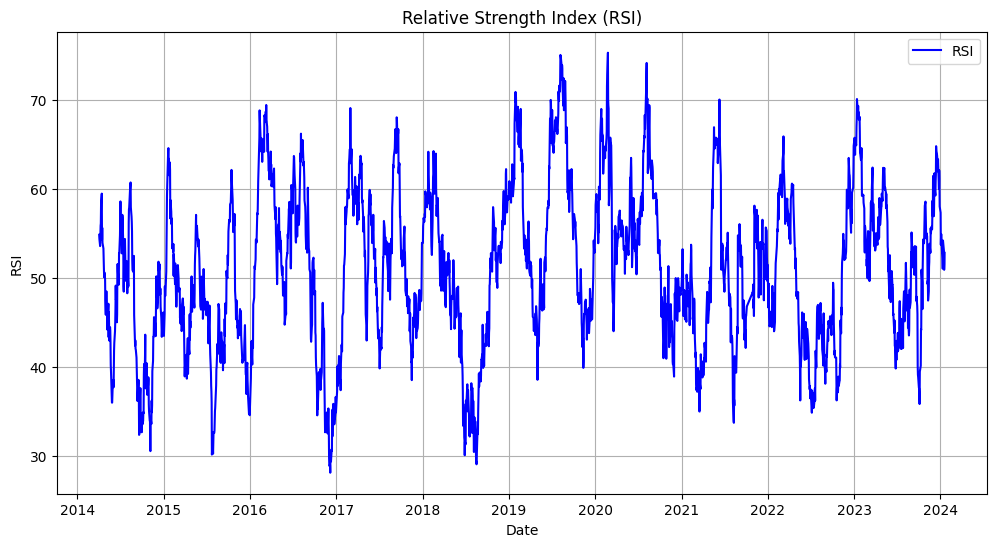

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, rsi_values, label='RSI', color='blue')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
!pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 7.6 MB/s eta 0:00:00


In [15]:
import backtrader as bt
class SupportResistanceStrategy(bt.Strategy):
    params = (
        ('support_level', 1000),
        ('resistance_level', 1200),
    )

    def __init__(self):
        self.support_level = self.params.support_level
        self.resistance_level = self.params.resistance_level

    def next(self):
        if self.data.close[0] > self.resistance_level:
            self.buy()
        elif self.data.close[0] < self.support_level:
            self.sell()


In [16]:
class DataFrameData(bt.feeds.PandasData):
    lines = ('support_level', 'resistance_level')
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', None),
        ('support_level', None),
        ('resistance_level', None),
    )
df['support_level'] = 1000
df['resistance_level'] = 1200

In [17]:
cerebro = bt.Cerebro()

data = DataFrameData(dataname=df)
cerebro.adddata(data)
cerebro.addstrategy(SupportResistanceStrategy)
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.001)
cerebro.run()

print('Final Portfolio Value:', cerebro.broker.getvalue())


Final Portfolio Value: 155041.4137


In [1]:
##Reverse trading strategies can be feasible for profit maximization in certain market conditions, such as range-bound markets, with careful consideration of risk management, adaptability, and psychological factors. However, they come with inherent challenges, including the need for accurate timing, effective strategy development, and management of whipsaws and market sentiment. Traders should assess the suitability of reverse trading strategies based on their risk tolerance, market expertise, and trading objectives.

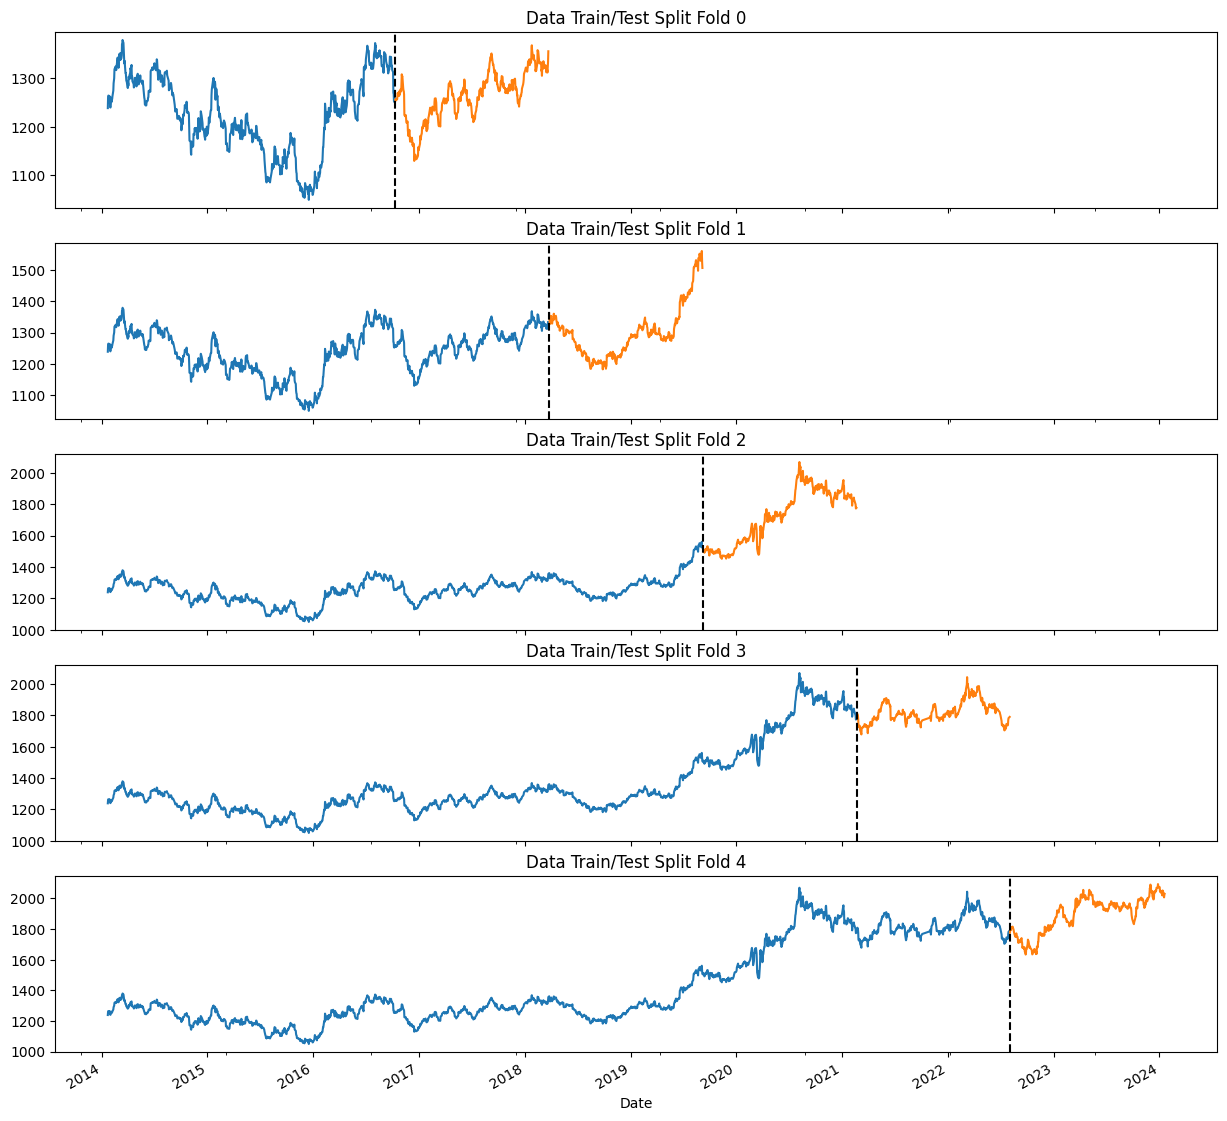

In [18]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [44]:
df=create_features(df)
df

,Close,Volume,Open,High,Low,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,
2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2,4,1,1,2024,19,19,3
2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7,3,1,1,2024,18,18,3
2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6,2,1,1,2024,17,17,3
2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6,1,1,1,2024,16,16,3
2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1,4,1,1,2024,12,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0,1,1,1,2014,28,28,5
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0,0,1,1,2014,27,27,5
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9,4,1,1,2014,24,24,4


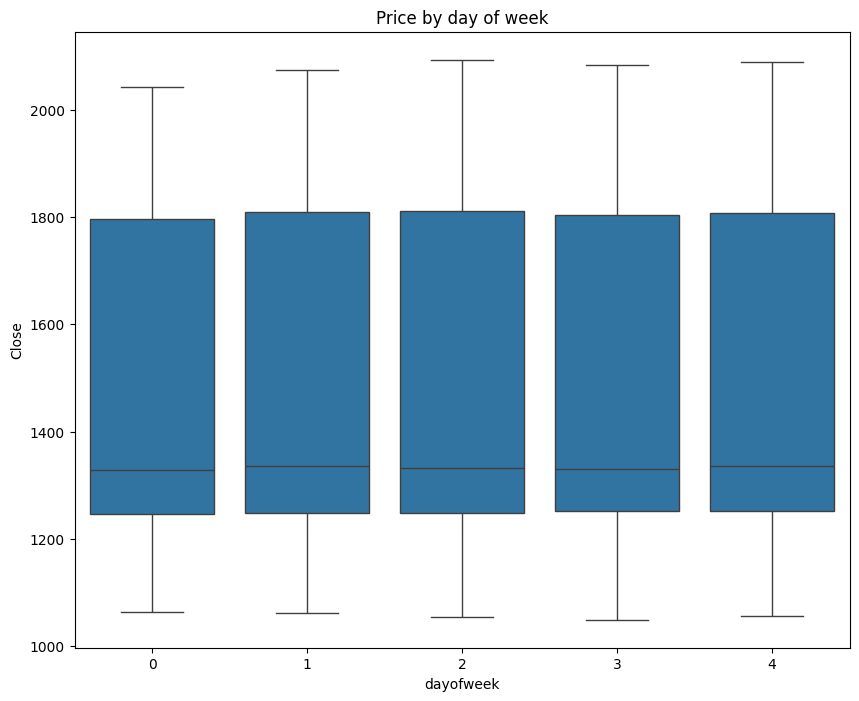

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Close')
ax.set_title('Price by day of week')
plt.show()

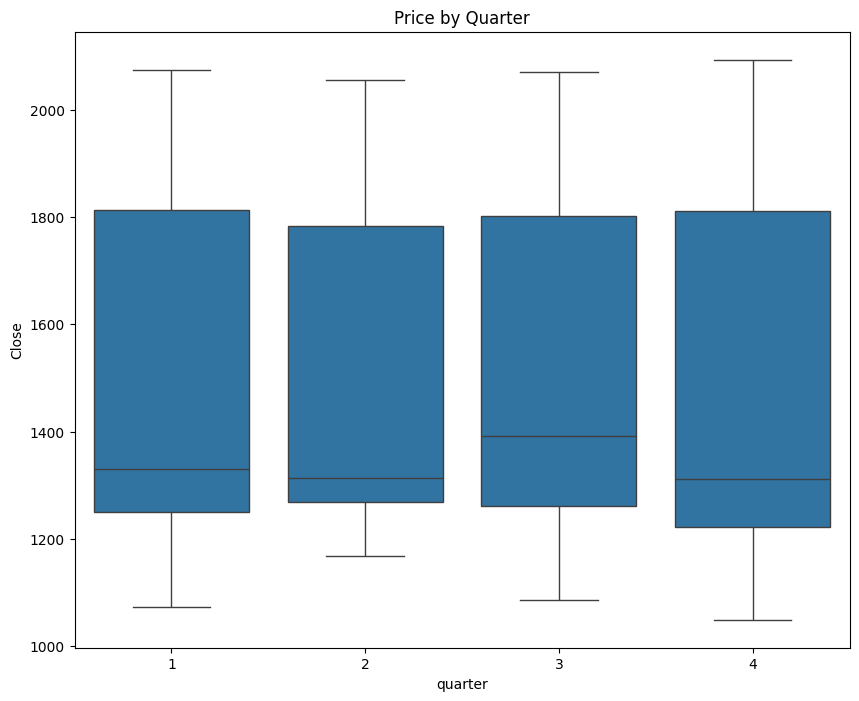

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='Close')
ax.set_title('Price by Quarter')
plt.show()

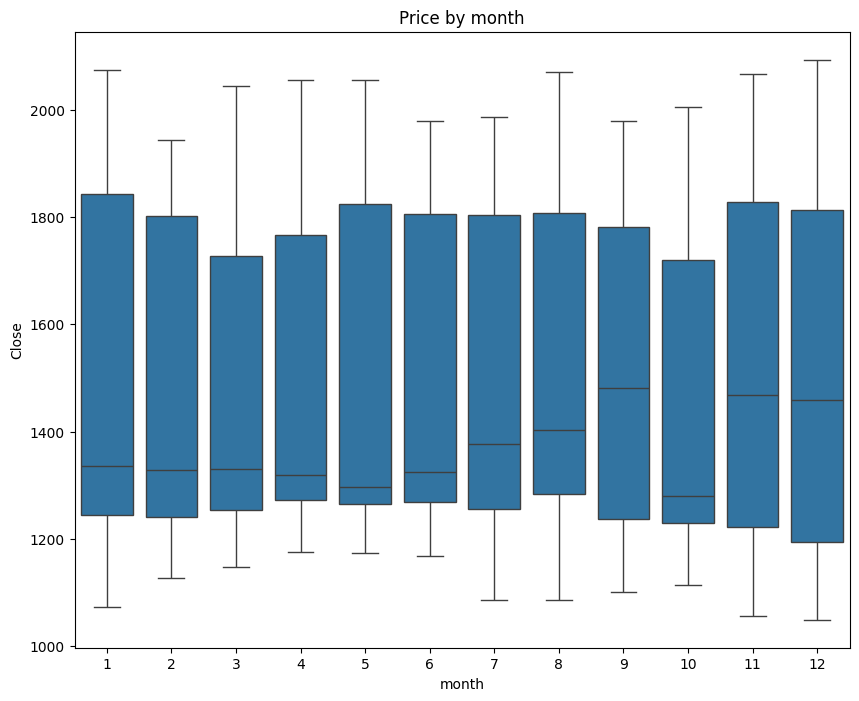

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Close')
ax.set_title('Price by month')
plt.show()

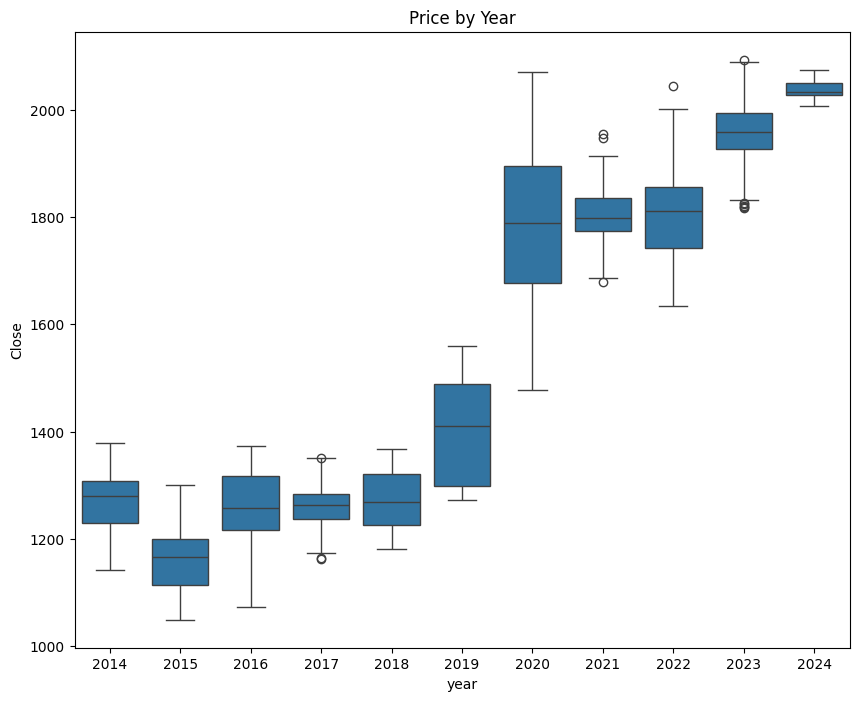

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='Close')
ax.set_title('Price by Year')
plt.show()

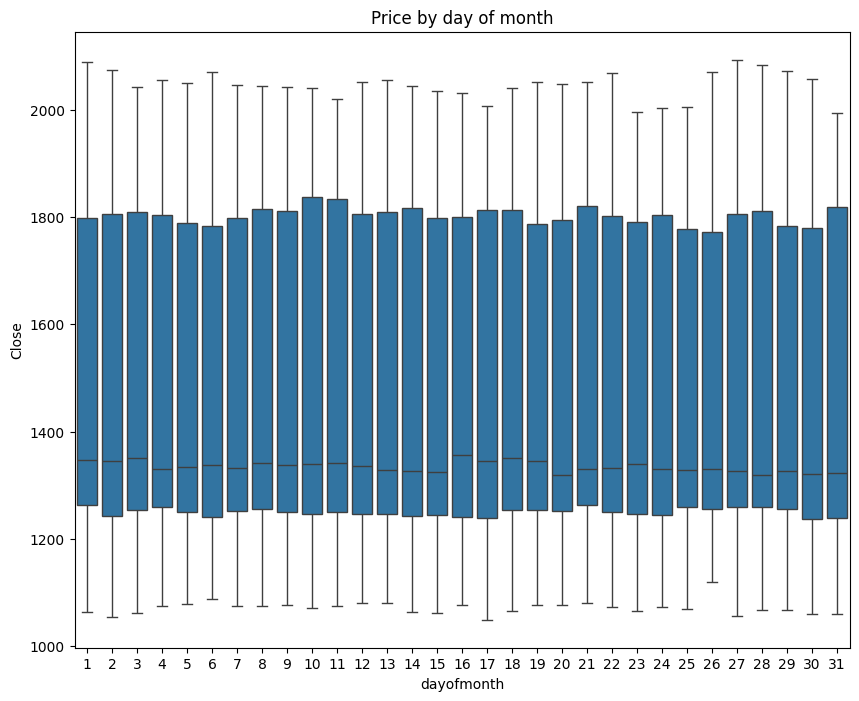

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofmonth', y='Close')
ax.set_title('Price by day of month')
plt.show()

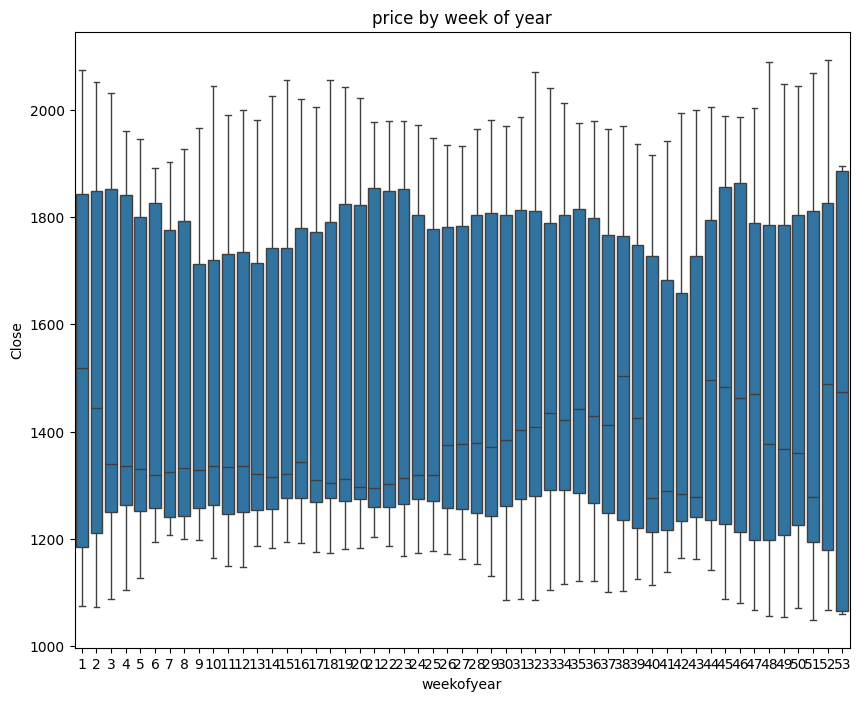

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='weekofyear', y='Close')
ax.set_title('price by week of year')
plt.show()

In [45]:
def add_lags(df):
    target_map = df['Close'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [46]:
df = add_lags(df)
df

,Close,Volume,Open,High,Low,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,
2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2,4,1,1,2024,19,19,3,1928.2,1834.1,1859.9
2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7,3,1,1,2024,18,18,3,1923.9,1844.9,1869.3
2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6,2,1,1,2024,17,17,3,1907.0,1845.5,1870.2
2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6,1,1,1,2024,16,16,3,1909.9,1812.4,1840.2
2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1,4,1,1,2024,12,12,2,1921.7,1816.5,1829.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0,1,1,1,2014,28,28,5,NaN,NaN,NaN
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0,0,1,1,2014,27,27,5,NaN,NaN,NaN
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9,4,1,1,2014,24,24,4,NaN,NaN,NaN


In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Close'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [29]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 173.9335
Fold scores:[126.45965839821736, 87.37681094123579, 432.3142920269437, 73.13387409438602, 150.38303890780003]


In [99]:
df = create_features(df)

FEATURES = ['dayofyear',  'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Close'

X_all = df[FEATURES]
y_all = df[TARGET]

In [56]:
stepfit= auto_arima(df['Close'],trace=True,supress_warnings=True)
stepfit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20602.538, Time=7.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20609.155, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20608.864, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20608.834, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20608.313, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20611.203, Time=3.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20610.985, Time=2.01 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=20606.153, Time=5.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=20612.076, Time=8.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20610.806, Time=1.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=20611.637, Time=3.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=20611.495, Time=2.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=20606.920, Time=10.74 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=20601.658, Time=2.05 sec
 ARIMA(1,1,2)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2511
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -10295.829
Date:                Sun, 03 Mar 2024   AIC                          20601.658
Time:                        07:02:36   BIC                          20630.799
Sample:                             0   HQIC                         20612.235
                               - 2511                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3388      0.013   -103.676      0.000      -1.364      -1.313
ar.L2         -0.9813      0.013    -73.754      0.000      -1.007      -0.955
ma.L1          1.3252      0.017     78.817      0.000       1.292       1.358
ma.L2          0.9669      0.017     55.273      0.000       0.933       1.001
sigma2       213.9976      3.266     65.528      0.000     207.597     220.398
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):              2703.75
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=700,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

lgb_model = lgb.LGBMRegressor(learning_rate=0.01,
                        n_estimators=700,
                        max_depth=4)

arima_model=ARIMA(df['Close'], order=(2, 1, 2))

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

lgb_model.fit(X_all,y_all,eval_set=[(X_all, y_all)])

arima_fit=arima_model.fit()


In [100]:
pred_xgb=reg.predict(X_all)
pred_lgm=lgb_model.predict(X_all)
pred_arima=arima_fit.predict(start=2400)

In [103]:
xgb_mse=mean_squared_error(y_all,pred_xgb)
lgm_mse=mean_squared_error(y_all,pred_lgm)
arima_mse=mean_squared_error(y_all[2400::],pred_arima)

xgb_rmse = np.sqrt(mean_squared_error(y_all, pred_xgb))
lgm_rmse = np.sqrt(mean_squared_error(y_all, pred_lgm))
arima_rmse = np.sqrt(mean_squared_error(y_all[2400:], pred_arima))

xgb_mae = mean_absolute_error(y_all, pred_xgb)
lgm_mae = mean_absolute_error(y_all, pred_lgm)
arima_mae = mean_absolute_error(y_all[2400:], pred_arima)

In [104]:
print("XGBoost MSE:", xgb_mse)
print("LightGBM MSE:", lgm_mse)
print("ARIMA MSE:", arima_mse)

print("\n")

print("XGBoost RMSE:", xgb_rmse)
print("LightGBM RMSE:", lgm_rmse)
print("ARIMA RMSE:", arima_rmse)

print("\n")

print("XGBoost MAE:", xgb_mae)
print("LightGBM MAE:", lgm_mae)
print("ARIMA MAE:", arima_mae)

XGBoost MSE: 1342.4120152044807
LightGBM MSE: 712.8487446901828
ARIMA MSE: 116.35314105478214


XGBoost RMSE: 36.63894124022255
LightGBM RMSE: 26.69922741747751
ARIMA RMSE: 10.7867113178569


XGBoost MAE: 28.41663458127987
LightGBM MAE: 20.24017424918005
ARIMA MAE: 7.855386158693078
